In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# from collections.abc import Sequence
from typing import Sequence
import torch
import numpy as np
import time

_SSM_NAME = "JackFram/llama-160m"
_LLM_NAME = 'openlm-research/open_llama_3b_v2'
device = "cuda"

assert torch.cuda.is_available()
tokenizer = AutoTokenizer.from_pretrained(_SSM_NAME)
ssm = AutoModelForCausalLM.from_pretrained(_SSM_NAME).cuda()
llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME, torch_dtype=torch.float16).cuda().eval()

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPU Profiling

In [13]:
from torch.profiler import profile, ProfilerActivity, schedule

# Guide: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

_N_ITERATIONS = 10
_WAIT_STEPS = 1
_WARMUP_STEPS = 1
schedule_params = {
    'wait': _WAIT_STEPS,
    'warmup': _WARMUP_STEPS,
    'active': _N_ITERATIONS - _WAIT_STEPS - _WARMUP_STEPS,
}
profiler_kwargs = {
    'activities': [ProfilerActivity.CPU, ProfilerActivity.CUDA],
    'profile_memory': True,
    'schedule': schedule(**schedule_params),
    'record_shapes': True,
    'with_stack': True,
    'on_trace_ready': torch.profiler.tensorboard_trace_handler('./log'),
}

from torch.nn.attention import SDPBackend, sdpa_kernel


def print_normal_profile_stats(input, model):
    with profile(**profiler_kwargs) as prof, torch.inference_mode(), sdpa_kernel(
        [SDPBackend.EFFICIENT_ATTENTION, SDPBackend.MATH, SDPBackend.CUDNN_ATTENTION]
    ):
        for _ in range(_N_ITERATIONS):
            model(input_ids=input)
            prof.step()

def print_tree_profile_stats(input, mask, position_ids, model):
    with profile(**profiler_kwargs) as prof, torch.inference_mode(), sdpa_kernel(
        [SDPBackend.EFFICIENT_ATTENTION, SDPBackend.MATH, SDPBackend.CUDNN_ATTENTION]
    ):
        for _ in range(_N_ITERATIONS):
            model(input_ids=input, attention_mask=mask, position_ids=position_ids)
            prof.step()

In [15]:
from experiments import create_token_tree, create_dummy_kv_cache, construct_tree_model_inputs, invert_4d_attention_mask
import numpy as np

expansion_config = [32] + [1] * 15
kv_size = 128

token_tree = create_token_tree(
        expansion_config=expansion_config,
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
        has_kv_cache=True
)
print(token_tree.shape)

kv_cache_sequential = create_dummy_kv_cache(
        kv_cache_num_tokens=kv_size,
        batch_size=np.prod(expansion_config),
        num_attention_heads=llm.config.num_attention_heads,
        hidden_size=llm.config.hidden_size,
        num_layers=llm.config.num_hidden_layers
)
print_normal_profile_stats(token_tree, llm)

tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
kv_cache_tree = create_dummy_kv_cache(
                    kv_cache_num_tokens=kv_size,
                    batch_size=1,
                    num_attention_heads=llm.config.num_attention_heads,
                    hidden_size=llm.config.hidden_size,
                    num_layers=llm.config.num_hidden_layers,
                )
print(tree_input.shape)
tree_mask = invert_4d_attention_mask(tree_mask, kv_size)

print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

torch.Size([32, 16])


STAGE:2024-06-11 01:01:30 578429:578429 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-06-11 01:01:31 578429:578429 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-11 01:01:31 578429:578429 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


torch.Size([1, 512])


STAGE:2024-06-11 01:01:43 578429:578429 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-06-11 01:01:44 578429:578429 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-11 01:01:44 578429:578429 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [20]:
# Measure max memory allocated
import gc

def reset_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()

def end_memory_collection():
    torch.cuda.synchronize()
    max_mem_gb = torch.cuda.max_memory_allocated() / 1024**3
    return max_mem_gb

token_tree = _create_token_tree([2, 2, 2], "The good dog is", tokenizer, ssm)
reset_memory()
time_normal(token_tree, llm, kv_cache=None)
seq_max_mem_gb = end_memory_collection()

tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
tree_mask = _invert_4d_attention_mask(tree_mask)
reset_memory()
time_tree(input_ids=tree_input, mask=tree_mask, position_ids=tree_position_ids, model=llm, kv_cache=None)
tree_max_mem_gb = end_memory_collection()

print(f"Normal: {seq_max_mem_gb} GB")
print(f"Tree: {tree_max_mem_gb} GB")

past key values None
past key values None
past key values None
Normal: 19.76176118850708 GB
Tree: 19.75322389602661 GB


In [21]:
import torch.utils.benchmark as benchmark
import numpy as np
import matplotlib.pyplot as plt

N_ITERATIONS = 32

tree_widths = [4] #range(1, 4)
sequential_times = []
tree_times = []

kv_cache_num_tokens = 128

for tree_width in tree_widths:
    expansion_config = (32, 1, 1, 1)

    token_tree = _create_token_tree(
        expansion_config=expansion_config,
        prompt="The good dog is",
        tokenizer=tokenizer,
        model=ssm,
    )
    print(token_tree)

    batch_size=np.prod(expansion_config)
    # kv_cache_sequential = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=batch_size,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    
    sequential_timer = benchmark.Timer(
        stmt="time_normal(input_ids, model, kv_cache)",
        setup="from __main__ import time_normal",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': token_tree,
            'model': llm,
            'kv_cache': None
        },
        label="Sequential"
    )
    
    
    sequential_measurement = sequential_timer.blocked_autorange(min_run_time=2)
    print('Sequential', sequential_measurement.median)
    
    # print(len(sequential_measurement.times))
    # print(sequential_measurement.mean)
    # sequential_times.append(sequential_measurement.times[-1])
    
    # construct inputs for tree decoding
    # kv_cache_tree = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=1,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
    # print(tree_input, tree_mask, tree_position_ids)
    # Required for 4D mask support in new HF
    # tree_mask = _invert_4d_attention_mask(tree_mask, kv_cache_num_tokens)

    tree_timer = benchmark.Timer(
        stmt="time_tree(input_ids, mask, position_ids, model, kv_cache_num_tokens, kv_cache)",
        setup="from __main__ import time_tree",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': tree_input,
            'mask': tree_mask,
            'position_ids': tree_position_ids,
            'model': llm,
            'kv_cache_num_tokens': 0,
            'kv_cache': None
        },
        label="Tree"
    )
    tree_measurement = tree_timer.blocked_autorange(min_run_time=2)
    print('Tree', tree_measurement.median)
    # tree_times.append(tree_measurement.times[-1])
    # violin = plt.violinplot([np.array(sequential_measurement.times) * 1000, np.array(tree_measurement.times) * 1000], showmeans=True)
    # plt.xticks([1, 2], ['Sequential', 'Tree'])
    # plt.ylabel("Latency (ms)")
    # plt.legend(handles = [violin['cmeans']],labels=['mean'])

    # print_normal_profile_stats(token_tree, llm)
    # print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

tensor([[    1,   450,  1781, 11203, 29892,   278,  1781, 11203],
        [    1,   450,  1781, 11203,   338,   263,  1781, 11203],
        [    1,   450,  1781, 11203, 29889,    13, 29902, 30010],
        [    1,   450,  1781, 11203, 12271,   674,   367,  2221],
        [    1,   450,  1781, 11203,   674,   367,   263,  1781],
        [    1,   450,  1781, 11203,   756,   263,  1781,  5192],
        [    1,   450,  1781, 11203,  1914,   414,  1073,   393],
        [    1,   450,  1781, 11203,   322,   278,  4319, 11203],
        [    1,   450,  1781, 11203,  9687,   338,   263,  2107],
        [    1,   450,  1781, 11203,   471,   263,  2586,   310],
        [    1,   450,  1781, 11203, 30010, 29879,  2834,   338],
        [    1,   450,  1781, 11203,   723,   505,  1063,   263],
        [    1,   450,  1781, 11203,   508,   367,   263,  1781],
        [    1,   450,  1781, 11203,  3841,   310, 11801,   526],
        [    1,   450,  1781, 11203,  4947,   263,  1781,  4982],
        [ 

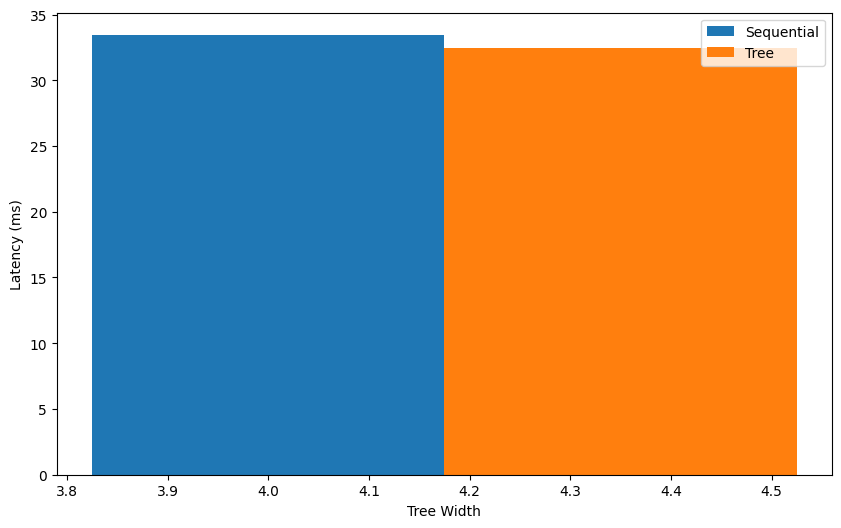

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.35
plt.figure(figsize=(10, 6))

x_data = tree_widths
y_sequential = np.array(sequential_times) * 1000 # scale to ms
plt.bar(x_data, y_sequential, label="Sequential", width=width)  # Plot the first list as the y-axis values
y_tree = np.array(tree_times) * 1000 # scale to ms
plt.bar([pos + width for pos in x_data], y_tree, label="Tree", width=width)  # Plot the second list as the y-axis values

plt.xlabel("Tree Width")
plt.ylabel("Latency (ms)")
plt.legend()

plt.show()
plt.savefig("tree_vs_sequential.png")

In [10]:
import metrics
from transformers import AutoConfig

mistral_7b_config = AutoConfig.from_pretrained("mistralai/Mistral-7B-v0.1")

metrics.identify_compute_memory_bound(
    gpu=metrics.T4,
    token_batch=torch.ones(1, np.sum(np.cumprod(expansion_config))),
    dtype=torch.float32,
    num_layers=mistral_7b_config.num_hidden_layers,
    d_model=mistral_7b_config.hidden_size,
    n_head=mistral_7b_config.num_attention_heads,
    vocab_size=mistral_7b_config.vocab_size,
    kv_cache_token_count=0
)

Memory-bound: arithmetic intensity 7.448872654272583 < 27.0


/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
import metrics

ratio = metrics.T4.tflops / metrics.T4.memory_bandwidth_tb_s
ratio

216.66666666666669

In [15]:
import itertools
import metrics
import numpy as np
import torch

_PROMPT_LENGTH = 0
gpu = metrics.A6000
kv_cache_token_length = 0

for expansion_config in [(2, 1, 1), (3, 1, 1, 1), (4, 1, 1), (16, 1, 1), (32, 1, 1)]:#itertools.product(range(2, 5), range(1, 4)):
    print(expansion_config, np.cumprod(expansion_config))
    print("Sequential")
    metrics.identify_compute_memory_bound(
        gpu=gpu,
        token_batch=torch.ones(np.prod(expansion_config), _PROMPT_LENGTH + len(expansion_config)),
        dtype=torch.float16,
        num_layers=llm.config.num_hidden_layers,
        d_model=llm.config.hidden_size,
        n_head=llm.config.num_attention_heads,
        vocab_size=llm.config.vocab_size,
        kv_cache_token_count=kv_cache_token_length  
    )
    print("Tree")
    metrics.identify_compute_memory_bound(
        gpu=gpu,
        token_batch=torch.ones(1, _PROMPT_LENGTH + np.sum(np.cumprod(expansion_config))),
        dtype=torch.float16,
        num_layers=llm.config.num_hidden_layers,
        d_model=llm.config.hidden_size,
        n_head=llm.config.num_attention_heads,
        vocab_size=llm.config.vocab_size,
        kv_cache_token_count=kv_cache_token_length
    )



(2, 1, 1) [2 2 2]
Sequential
0.00661912418
Memory-bound: arithmetic intensity 5.978649773571705 < 94.89583333333333
Tree
0.0066193052959999995
Memory-bound: arithmetic intensity 5.9794024886444825 < 94.89583333333333
(3, 1, 1, 1) [3 3 3 3]
Sequential
0.006643808064
Memory-bound: arithmetic intensity 11.913482947962537 < 94.89583333333333
Tree
0.006644773184
Memory-bound: arithmetic intensity 11.91662078559219 < 94.89583333333333
(4, 1, 1) [4 4 4]
Sequential
0.006643687892
Memory-bound: arithmetic intensity 11.91308981496628 < 94.89583333333333
Tree
0.006644773184
Memory-bound: arithmetic intensity 11.91662078559219 < 94.89583333333333
(16, 1, 1) [16 16 16]
Sequential
0.006791070164
Memory-bound: arithmetic intensity 46.61819044636806 < 94.89583333333333
Tree
0.0068127549439999996
Memory-bound: arithmetic intensity 46.5766402062443 < 94.89583333333333
(32, 1, 1) [32 32 32]
Sequential
0.00698757986
Memory-bound: arithmetic intensity 90.61432100469762 < 94.89583333333333
Tree
0.0070771957

### Full Decoding Experiment

In [76]:
from experiments import create_token_tree, create_dummy_kv_cache, construct_tree_model_inputs, invert_4d_attention_mask
from tqdm import tqdm
import torch.utils.benchmark as benchmark


expansion_config = [8] + [1] * 15

kv_cache_max_size = 512
num_tokens_accepted = 8
results = {}
sequential_cache = {}
tree_cache = {}
for switch_step in tqdm(range(0, 449, 64)):
    total_time = 0
    num_tokens_decoded = 0
    for kv_cache_size in tqdm(range(0, kv_cache_max_size, num_tokens_accepted)):
        token_tree = create_token_tree(
            expansion_config=expansion_config,
            prompt="The",
            tokenizer=tokenizer,
            model=ssm,
            has_kv_cache=kv_cache_size > 0
        )
        run_sequential = True
        if num_tokens_decoded >= switch_step:
            run_sequential = False
        
        print(f"Switch step: {switch_step}, kv_cache_size: {kv_cache_size}, run_sequential: {run_sequential}")
        if run_sequential:
            if kv_cache_size in sequential_cache:
                measurement = sequential_cache[kv_cache_size]
            else:
                batch_size=np.prod(expansion_config)
                kv_cache_sequential = create_dummy_kv_cache(
                    kv_cache_num_tokens=kv_cache_size,
                    batch_size=batch_size,
                    num_attention_heads=llm.config.num_attention_heads,
                    hidden_size=llm.config.hidden_size,
                    num_layers=llm.config.num_hidden_layers
                )
                
                timer = benchmark.Timer(
                    stmt="time_normal(input_ids, model, kv_cache)",
                    setup="from experiments import time_normal",
                    num_threads=torch.get_num_threads(),
                    globals={
                        'input_ids': token_tree,
                        'model': llm,
                        'kv_cache': kv_cache_sequential
                    },
                    label="Sequential"
                )
                measurement = timer.blocked_autorange(min_run_time=2).median
                sequential_cache[kv_cache_size] = measurement
        else:
            if kv_cache_size in tree_cache:
                measurement = tree_cache[kv_cache_size]
            else:
                tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)

                kv_cache_tree = create_dummy_kv_cache(
                    kv_cache_num_tokens=kv_cache_size,
                    batch_size=1,
                    num_attention_heads=llm.config.num_attention_heads,
                    hidden_size=llm.config.hidden_size,
                    num_layers=llm.config.num_hidden_layers
                )
                timer = benchmark.Timer(
                    stmt="time_tree(input_ids, mask, position_ids, model, kv_cache_num_tokens, kv_cache)",
                    setup="from experiments import time_tree",
                    num_threads=torch.get_num_threads(),
                    globals={
                        'input_ids': tree_input,
                        'mask': tree_mask,
                        'position_ids': tree_position_ids,
                        'model': llm,
                        'kv_cache_num_tokens': kv_cache_size,
                        'kv_cache': kv_cache_tree
                    },
                    label="Tree"
                )
                measurement = timer.blocked_autorange(min_run_time=2).median
                tree_cache[kv_cache_size] = measurement
        total_time += measurement
        num_tokens_decoded += num_tokens_accepted
    print(f"Switch step: {switch_step}, total time: {total_time}")
    results[switch_step] = total_time

    

  0%|          | 0/8 [00:00<?, ?it/s]

Switch step: 0, kv_cache_size: 0, run_sequential: False


Switch step: 0, kv_cache_size: 8, run_sequential: False


In [75]:
sequential_cache

{0: 0.019294712133705615,
 8: 0.018493074737489224,
 16: 0.01855852883309126,
 24: 0.018485596776008605,
 32: 0.018476522900164126,
 40: 0.018498830497264862,
 48: 0.01850793045014143,
 56: 0.01852269433438778,
 64: 0.01854089219123125,
 72: 0.018520110473036765,
 80: 0.018564048781991006,
 88: 0.0185483792796731,
 96: 0.019028143398463725,
 104: 0.0185831343755126,
 112: 0.018501446582376957,
 120: 0.018820739537477493,
 128: 0.018474785983562468,
 136: 0.01855798400938511,
 144: 0.01835933942347765,
 152: 0.01752457832917571,
 160: 0.018496111780405045,
 168: 0.018541529960930347,
 176: 0.01851376537233591,
 184: 0.018395432829856874}

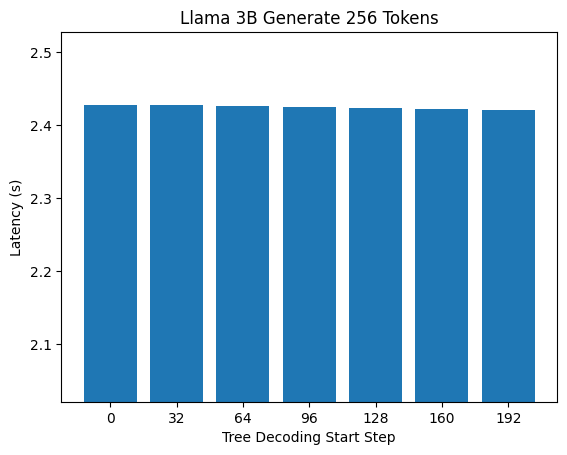

In [69]:
import matplotlib.pyplot as plt

data = results
keys = list(range(len(data)))
values = list(data.values())

# Create the bar plot
plt.figure()
plt.bar(keys, values)

# Add title and labels
plt.title('Llama 3B Generate 256 Tokens')
plt.xlabel('Tree Decoding Start Step')
plt.ylabel('Latency (s)')
plt.ylim(min(values) - 0.4, max(values) + 0.1)
plt.xticks(ticks=range(len(keys)), labels=[str(i) for i in range(0, 193, 32)])

# Display the plot
plt.show()

In [36]:
tree_cache

{0: 0.017771319299936295,
 2: 0.018579963594675064,
 4: 0.01884776595979929,
 6: 0.018956327624619008,
 8: 0.018980447947978974,
 10: 0.0189638813957572,
 12: 0.018861678801476954,
 14: 0.018838932923972606,
 16: 0.018833108060061932,
 18: 0.018817970342934132,
 20: 0.018763555213809013,
 22: 0.018854705803096294,
 24: 0.01889476105570793,
 26: 0.01887859106063843,
 28: 0.01895089354366064,
 30: 0.018930079601705074,
 32: 0.01892057079821825,
 34: 0.01885865181684494,
 36: 0.018881631456315516,
 38: 0.019046703912317754,
 40: 0.018864456564188004,
 42: 0.018599607236683368,
 44: 0.018856633640825748,
 46: 0.018803122267127038,
 48: 0.018794121406972408,
 50: 0.018799219653010367,
 52: 0.018835098668932914,
 54: 0.018761929124593735,
 56: 0.018788436613976955,
 58: 0.018927660770714283,
 60: 0.018890326283872126,
 62: 0.018874009139835835,
 64: 0.018830655701458456,
 66: 0.018838606774806976,
 68: 0.018806563317775728,
 70: 0.018851064331829547,
 72: 0.018841281719505786,
 74: 0.0187724